In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, SubsetRandomSampler, DataLoader,Subset
from torch.optim import Adam
from torchvision.models import resnet50

from collections import Counter
import itertools

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CONSTANTS
DATASET_DIR = 'data/'
NUM_CLASSES = 12 # no of classes in the garbage dataset
BATCH_SIZE = 32 # for dataloader
NUM_FOLDS = 2 # for stratified k-fold
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
LOSS_FN = nn.CrossEntropyLoss()

cuda


In [3]:
# Resize images before passing it to the model
transformations = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                     ])
dataset = ImageFolder(DATASET_DIR, transform = transformations)
CLASSES = dataset.class_to_idx.keys()
print('Total dataset',len(dataset))
print('Classes')
display(dataset.class_to_idx)

Total dataset 15515
Classes


{'battery': 0,
 'biological': 1,
 'brown-glass': 2,
 'cardboard': 3,
 'clothes': 4,
 'green-glass': 5,
 'metal': 6,
 'paper': 7,
 'plastic': 8,
 'shoes': 9,
 'trash': 10,
 'white-glass': 11}

Image sampled from class 0 - "battery"


<Figure size 1008x504 with 0 Axes>

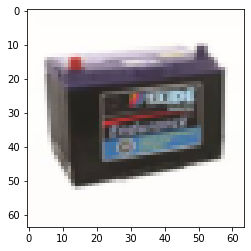

<Figure size 1008x504 with 0 Axes>

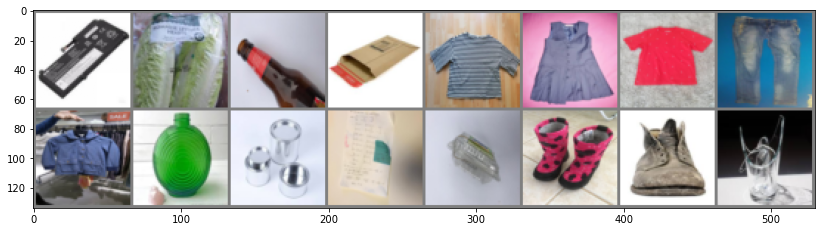

In [4]:
def imshow(image):
    plt.figure(figsize=(14,7))
    if not isinstance(image,torch.Tensor):
        plt.figure(figsize=(4,4))
        print(f'Image sampled from class {image[1]} - "{dataset.classes[image[1]]}"')
        npimg = np.array(image[0])
    else:
        plt.figure(figsize=(14,7))
        npimg = image.numpy()
    npimg = npimg / 2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(dataset[20])
imshow(make_grid([dataset[idx][0] for idx in range(1,len(dataset),1000)]))

In [5]:
all_idxs = np.arange(len(dataset))
train_idxs, test_idxs = train_test_split(all_idxs, test_size=0.3,stratify=dataset.targets, random_state=0)
train_labels = np.array(dataset.targets)[train_idxs]
test_labels = np.array(dataset.targets)[test_idxs]
print('train dataset',len(train_idxs))
print('test dataset',len(test_idxs))

train dataset 10860
test dataset 4655


<BarContainer object of 12 artists>

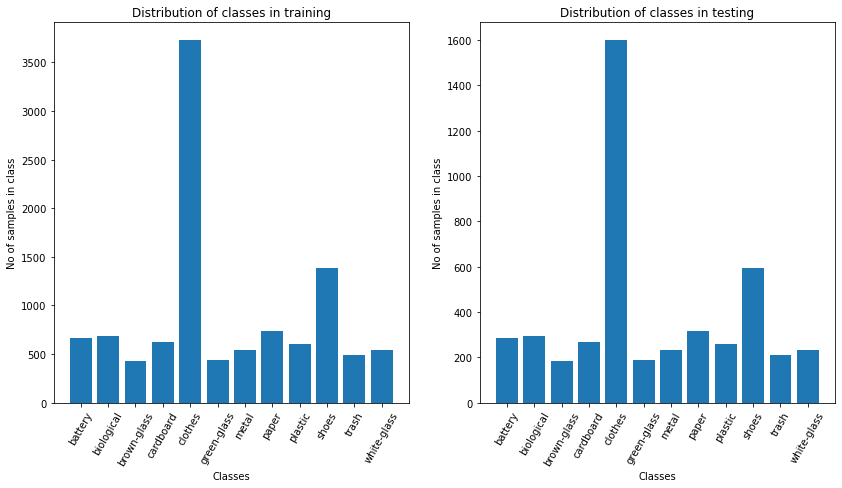

In [6]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title('Distribution of classes in training')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
train_labels_dist = Counter(train_labels)
plt.bar(train_labels_dist.keys(), train_labels_dist.values())
plt.subplot(1,2,2)
plt.title('Distribution of classes in testing')
plt.xlabel('Classes')
plt.ylabel('No of samples in class')
plt.xticks(np.arange(NUM_CLASSES),CLASSES, rotation = 60)
test_labels_dist = Counter(test_labels)
plt.bar(test_labels_dist.keys(), test_labels_dist.values())

In [7]:
class GarbageClassifierCNN(nn.Module):
    def __init__(self, kernel_size=5, padding=1):
        super(GarbageClassifierCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=kernel_size, padding=padding),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(14 * 14 * 32, 8*8*8),
            nn.ReLU(inplace=True),
            nn.Linear(8*8*8, NUM_CLASSES))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class ResNetClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = resnet50(pretrained=True)
        for param in self.nn.parameters():
            param.requires_grad = False
        self.nn.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, NUM_CLASSES))
#         num_features = self.nn.fc.in_features
#         self.nn.final = nn.Linear(num_features, NUM_CLASSES)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.nn(x))

In [8]:
@torch.no_grad()
def evaluate_model(model,loader):
    model.to('cpu')
    # set model to evaluation mode before evaluation
    model.eval()
    predictions = torch.tensor([])
    targets = torch.tensor([])

    for _, (images, labels) in enumerate(tqdm(loader)):
        out = model(images)
        _, predicted = torch.max(out.data, 1)
        targets = torch.cat((targets, labels))
        predictions = torch.cat((predictions, predicted))

    accuracy = accuracy_score(targets, predictions) * 100
    f1 = f1_score(targets, predictions, average='macro')
    recall = recall_score(targets, predictions, average='macro')
    precision = precision_score(targets, predictions, average='macro')
    conf_matrix = confusion_matrix(targets, predictions)
    return conf_matrix,[accuracy, f1, recall, precision]

In [9]:
def plot_cm(cm, classes, normalize=False, title='Visualization of the confusion matrix', cmap=plt.cm.Reds):
    plt.figure(figsize=(14,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    
    plt.ylabel('Actual True label')
    plt.xlabel('Predicted label')

In [10]:
def training_loop(k_fold_num,model,train_loader, optimizer, total_step):
    epoch_metrics = []
    for epoch in range(NUM_EPOCHS):
        loss_val = 0.0
        acc_val = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = LOSS_FN(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            loss_val += loss.item()
            acc_val += (correct / total) * 100
            if i % 10 == 0:
                print(f'Epoch [{epoch + 1}/{NUM_EPOCHS}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}, Accuracy: {(correct / total) * 100:.2f}')
        {'fold':k_fold_num,'epoch':epoch,'loss':loss_val/i,'accuracy':acc_val/i}
        epoch_metrics.append({'fold':k_fold_num,'epoch':epoch,'loss':loss_val/i,'accuracy':acc_val/i})

    torch.save(model.state_dict(), "./model.pt")
    return epoch_metrics
    

In [11]:
def run_kfold(model):
    total_scores = []
    total_confusion_matrix = np.zeros((NUM_CLASSES,NUM_CLASSES))
    kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True)
    epoch_metrics_df = pd.DataFrame(columns=['fold','epoch','loss','accuracy'])
    for k_fold_num, (train_index, test_index) in enumerate(kf.split(train_idxs,train_labels)):
        model.to(device)
        print('Running K-Fold -', k_fold_num)
        train_fold = Subset(dataset, train_idxs[train_index])
        test_fold = Subset(dataset, train_idxs[test_index])

        train_loader = DataLoader(train_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
        test_loader = DataLoader(test_fold, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

        optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
        total_step = len(train_loader)

        epoch_metrics = training_loop(k_fold_num,model,train_loader, optimizer, total_step)
        epoch_metrics_df = epoch_metrics_df.append(epoch_metrics,ignore_index=True)
        conf_matrix, scores = evaluate_model(model,test_loader)

        total_scores.append(scores)
        total_confusion_matrix = np.add(total_confusion_matrix,conf_matrix)

    scores_df = pd.DataFrame(total_scores,columns=['accuracy', 'f1', 'recall', 'precision'])
    return scores_df,epoch_metrics_df, total_confusion_matrix

In [12]:
scores_df,epoch_metrics_df, total_confusion_matrix = run_kfold(ResNetClassifier())

Running K-Fold - 0
Epoch [1/2], Step [1/169], Loss: 2.4820, Accuracy: 6.25
Epoch [1/2], Step [11/169], Loss: 2.3153, Accuracy: 25.00
Epoch [1/2], Step [21/169], Loss: 2.1368, Accuracy: 28.12
Epoch [1/2], Step [31/169], Loss: 2.0013, Accuracy: 40.62
Epoch [1/2], Step [41/169], Loss: 1.9992, Accuracy: 37.50
Epoch [1/2], Step [51/169], Loss: 2.1875, Accuracy: 21.88
Epoch [1/2], Step [61/169], Loss: 2.0335, Accuracy: 28.12
Epoch [1/2], Step [71/169], Loss: 2.0566, Accuracy: 21.88
Epoch [1/2], Step [81/169], Loss: 2.0024, Accuracy: 34.38
Epoch [1/2], Step [91/169], Loss: 2.0156, Accuracy: 43.75
Epoch [1/2], Step [101/169], Loss: 1.9522, Accuracy: 65.62
Epoch [1/2], Step [111/169], Loss: 1.8938, Accuracy: 71.88
Epoch [1/2], Step [121/169], Loss: 1.9135, Accuracy: 62.50
Epoch [1/2], Step [131/169], Loss: 1.9158, Accuracy: 53.12
Epoch [1/2], Step [141/169], Loss: 1.9670, Accuracy: 62.50
Epoch [1/2], Step [151/169], Loss: 1.8982, Accuracy: 71.88
Epoch [1/2], Step [161/169], Loss: 2.1034, Accura

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [01:18<00:00,  2.14it/s]
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Running K-Fold - 1
Epoch [1/2], Step [1/169], Loss: 1.8746, Accuracy: 71.88
Epoch [1/2], Step [11/169], Loss: 1.8385, Accuracy: 65.62
Epoch [1/2], Step [21/169], Loss: 1.8387, Accuracy: 75.00
Epoch [1/2], Step [31/169], Loss: 1.8475, Accuracy: 71.88
Epoch [1/2], Step [41/169], Loss: 1.8118, Accuracy: 81.25
Epoch [1/2], Step [51/169], Loss: 1.8435, Accuracy: 81.25
Epoch [1/2], Step [61/169], Loss: 1.7798, Accuracy: 78.12
Epoch [1/2], Step [71/169], Loss: 1.8761, Accuracy: 65.62
Epoch [1/2], Step [81/169], Loss: 1.7890, Accuracy: 78.12
Epoch [1/2], Step [91/169], Loss: 1.8326, Accuracy: 71.88
Epoch [1/2], Step [101/169], Loss: 1.7895, Accuracy: 87.50
Epoch [1/2], Step [111/169], Loss: 1.8070, Accuracy: 62.50
Epoch [1/2], Step [121/169], Loss: 1.8084, Accuracy: 78.12
Epoch [1/2], Step [131/169], Loss: 1.8376, Accuracy: 78.12
Epoch [1/2], Step [141/169], Loss: 1.7812, Accuracy: 87.50
Epoch [1/2], Step [151/169], Loss: 1.8336, Accuracy: 75.00
Epoch [1/2], Step [161/169], Loss: 1.8256, Accur

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [01:18<00:00,  2.15it/s]


In [13]:
# scores_df,epoch_metrics_df, total_confusion_matrix = run_kfold(GarbageClassifierCNN())

Confusion matrix, without normalization


,fold,epoch,loss,accuracy
0,0,0,2.019711,46.707589
1,0,1,1.875969,71.372768
2,1,0,1.849366,74.274554
3,1,1,1.806791,78.962054


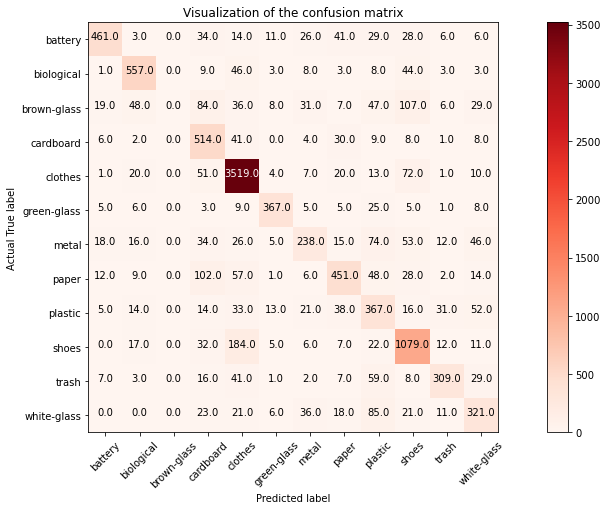

In [16]:
plot_cm(total_confusion_matrix, CLASSES)
epoch_metrics_df

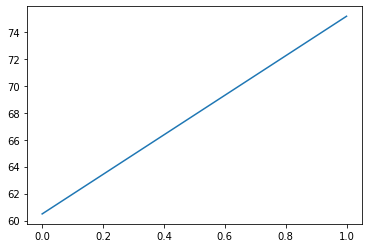

In [15]:
temp_df = epoch_metrics_df.groupby('epoch').mean()

plt.plot(temp_df.index.values,temp_df.accuracy.values)
